In this notebook, we demonstrate how to:

1. reproject the ASF radiometric and terrain corrected data into a single coordinate reference system.
2. crop the data to a smaller area
3. filter the time series according to month if relevant

In [1]:
import rasterio
from pathlib import Path
from tqdm import tqdm
import lxml.etree as etree
import datetime
import numpy as np
import matplotlib.pyplot as plt
from rscube import (get_cropped_profile,
                    reproject_arr_to_match_profile,
                    reproject_arr_to_match_profile)

# Setting Data Paths

You should have all the data downloaded using the example from the previous notebook in the directory:

```
./data/asf_data/
```

In [2]:
DATA_DIR_NAME = f'data/asf_data/'
DATA_DIR = Path(DATA_DIR_NAME)
DATA_DIR.exists()

True

In [3]:
hh_paths = sorted(list(DATA_DIR.glob('*/*HH.tif')))
hv_paths = sorted(list(DATA_DIR.glob('*/*HV.tif')))
dem_paths = sorted(list(DATA_DIR.glob('*/*dem*.tif')))
metadata_paths = sorted(list(DATA_DIR.glob('*/*iso.xml')))
metadata_paths, dem_paths

([PosixPath('data/asf_data/AP_08513_FBD_F0080_RT2/AP_08513_FBD_F0080_RT2.iso.xml'),
  PosixPath('data/asf_data/AP_09855_FBD_F0080_RT2/AP_09855_FBD_F0080_RT2.iso.xml'),
  PosixPath('data/asf_data/AP_13210_FBD_F0080_RT2/AP_13210_FBD_F0080_RT2.iso.xml'),
  PosixPath('data/asf_data/AP_14552_FBD_F0080_RT2/AP_14552_FBD_F0080_RT2.iso.xml'),
  PosixPath('data/asf_data/AP_23946_FBD_F0080_RT2/AP_23946_FBD_F0080_RT2.iso.xml'),
  PosixPath('data/asf_data/AP_24617_FBD_F0080_RT2/AP_24617_FBD_F0080_RT2.iso.xml'),
  PosixPath('data/asf_data/AP_25288_FBD_F0080_RT2/AP_25288_FBD_F0080_RT2.iso.xml')],
 [PosixPath('data/asf_data/AP_08513_FBD_F0080_RT2/AP_08513_FBD_F0080_RT2.dem.tif'),
  PosixPath('data/asf_data/AP_09855_FBD_F0080_RT2/AP_09855_FBD_F0080_RT2.dem.tif'),
  PosixPath('data/asf_data/AP_13210_FBD_F0080_RT2/AP_13210_FBD_F0080_RT2.dem.tif'),
  PosixPath('data/asf_data/AP_14552_FBD_F0080_RT2/AP_14552_FBD_F0080_RT2.dem.tif'),
  PosixPath('data/asf_data/AP_23946_FBD_F0080_RT2/AP_23946_FBD_F0080_RT2.de

# Inspect Profiles

In [4]:
def get_profile(path):
    with rasterio.open(path) as ds:
        p = ds.profile
    return p
profiles = [get_profile(p) for p in hh_paths]
profiles

[{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 2694, 'height': 2398, 'count': 1, 'crs': CRS.from_epsg(32647), 'transform': Affine(30.0, 0.0, 661704.5625,
        0.0, -30.0, 577654.4375), 'tiled': False, 'compress': 'packbits', 'interleave': 'band'},
 {'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 2692, 'height': 2405, 'count': 1, 'crs': CRS.from_epsg(32647), 'transform': Affine(30.0, 0.0, 661569.5625,
        0.0, -30.0, 577369.4375), 'tiled': False, 'compress': 'packbits', 'interleave': 'band'},
 {'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 2690, 'height': 2395, 'count': 1, 'crs': CRS.from_epsg(32647), 'transform': Affine(30.0, 0.0, 661029.5625,
        0.0, -30.0, 577699.4375), 'tiled': False, 'compress': 'packbits', 'interleave': 'band'},
 {'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 2692, 'height': 2402, 'count': 1, 'crs': CRS.from_epsg(32647), 'transform': Affine(30.0, 0.0, 661629.5625,
        0.0, -30.0, 5

# Get Dates

The ASF data is distributed with an xml file and we have determined which item contains the date and we extract that. This will work with ASF RTC ALOS-1 images only. Each sensor will have data stored in a different file and in a different format.

In [5]:
def get_alos_date(metadata_xml_path):
    tree = etree.parse(open(metadata_xml_path))
    root = tree.getroot()

    dataAcquisition_elements = root.xpath('//gml:beginPosition', namespaces=root.nsmap)
    assert(len(dataAcquisition_elements) == 1)
    element = dataAcquisition_elements[0].text
    date = datetime.date(int(element[:4]), int(element[5:7]), int(element[8:10]))
    return date

In [6]:
dates = list(map(get_alos_date, metadata_paths))
dates

[datetime.date(2007, 8, 30),
 datetime.date(2007, 11, 30),
 datetime.date(2008, 7, 17),
 datetime.date(2008, 10, 17),
 datetime.date(2010, 7, 23),
 datetime.date(2010, 9, 7),
 datetime.date(2010, 10, 23)]

# Filter by Date

We only want the spring and summer months (April - September).

In [7]:
# This means we only reserve months 4, ..., 9
MONTHS_TO_USE = list(range(4, 10))
MONTHS_TO_USE

[4, 5, 6, 7, 8, 9]

In [8]:
indices = [k for k, date in enumerate(dates) if date.month in MONTHS_TO_USE]
indices

[0, 2, 4, 5]

In [9]:
metadata_paths_filtered = [metadata_paths[k] for k in indices]
dem_paths_filtered = [dem_paths[k] for k in indices]
hv_paths_filtered = [hv_paths[k] for k in indices]
hh_paths_filtered = [hh_paths[k] for k in indices]

In [10]:
profiles = [get_profile(p) for p in hh_paths_filtered]
profiles

[{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 2694, 'height': 2398, 'count': 1, 'crs': CRS.from_epsg(32647), 'transform': Affine(30.0, 0.0, 661704.5625,
        0.0, -30.0, 577654.4375), 'tiled': False, 'compress': 'packbits', 'interleave': 'band'},
 {'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 2690, 'height': 2395, 'count': 1, 'crs': CRS.from_epsg(32647), 'transform': Affine(30.0, 0.0, 661029.5625,
        0.0, -30.0, 577699.4375), 'tiled': False, 'compress': 'packbits', 'interleave': 'band'},
 {'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 2694, 'height': 2403, 'count': 1, 'crs': CRS.from_epsg(32647), 'transform': Affine(30.0, 0.0, 661929.5625,
        0.0, -30.0, 577849.4375), 'tiled': False, 'compress': 'packbits', 'interleave': 'band'},
 {'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 2692, 'height': 2402, 'count': 1, 'crs': CRS.from_epsg(32647), 'transform': Affine(30.0, 0.0, 661869.5625,
        0.0, -30.0, 5

# Get Cropped Subset

We are going to view one area and get a subset and reproject all the other images into that frame.

In [11]:
with rasterio.open(hv_paths[1]) as ds:
    X = ds.read(1)
    mask = ~ds.read_masks(1).astype(bool)
    X[mask] = np.nan

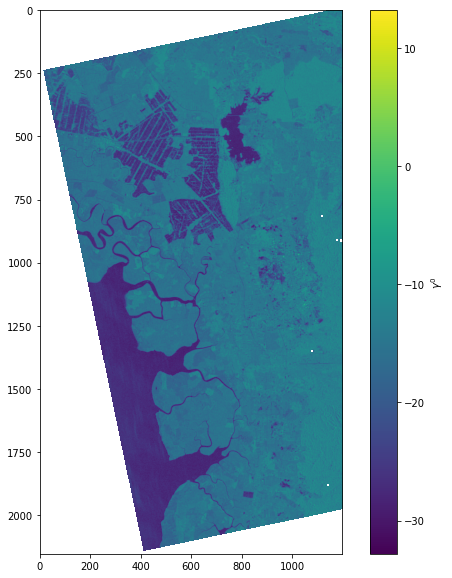

In [12]:
sy = np.s_[250:]
sx = np.s_[:1200]

plt.figure(figsize=(10, 10))
plt.imshow(10* np.log10(X[sy, sx]))
plt.colorbar(label='$\gamma^0$')

In [13]:
with rasterio.open(hv_paths[0]) as ds:
    PROFILE = ds.profile

CROPPED_PROFILE = get_cropped_profile(PROFILE, sx, sy)
CROPPED_PROFILE['nodata'] = np.nan
CROPPED_PROFILE

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 1200, 'height': 2148, 'count': 1, 'crs': CRS.from_epsg(32647), 'transform': Affine(30.0, 0.0, 661704.5625,
       0.0, -30.0, 570154.4375), 'tiled': False, 'compress': 'packbits', 'interleave': 'band'}

In [14]:
REFERENCE_PROFILE = CROPPED_PROFILE.copy()
REFERENCE_PROFILE['nodata'] = np.nan

In [15]:
def read_one(tif_path):
    with rasterio.open(tif_path) as ds:
        img = ds.read(1)
        profile = ds.profile
        mask = (img == 0)
        img[mask] = np.nan
    profile['nodata'] = np.nan
    return img, profile

def reproject_one(tif_path):
    img_src, profile_src = read_one(tif_path)
    
    img_r, profile_r = reproject_arr_to_match_profile(img_src, 
                                                      profile_src, 
                                                      REFERENCE_PROFILE, 
                                                      resampling='bilinear')
    # Clips image to between -30 and 0 db.
    img_r = np.clip(img_r, 1e-3, 1)
    
    return img_r, profile_r

def write_reprojected(img_r, original_tif_path, metadata_path, pol):
    date = get_alos_date(metadata_path)

    dest_dir = Path(f'{DATA_DIR}_reprojected/{pol}')
    dest_dir.mkdir(exist_ok=True, parents=True)
    dest_path = dest_dir/f'ALOS1_RTC_{pol}_{date.year}{date.month:02d}{date.day:02d}.tif'

    with rasterio.open(dest_path, 'w', **REFERENCE_PROFILE) as ds:
        ds.write(img_r.astype(REFERENCE_PROFILE['dtype']))
    return dest_path

In [16]:
reprojected_data_hh = list(map(reproject_one, tqdm(hh_paths_filtered)))
reprojected_images_hh, _ = zip(*reprojected_data_hh)

100%|██████████| 4/4 [00:00<00:00,  4.83it/s]


In [17]:
reprojected_data_hv = list(map(reproject_one, tqdm(hv_paths_filtered)))
reprojected_images_hv, _ = zip(*reprojected_data_hv)

100%|██████████| 4/4 [00:00<00:00,  4.96it/s]


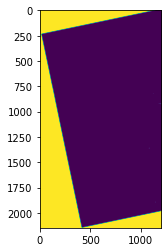

In [18]:
from functools import reduce
def find_mask(img_0, img_1):
    return np.isnan(img_0) | np.isnan(img_1)

ts_mask = list(reduce(find_mask, reprojected_images_hh + reprojected_images_hv))[0]
plt.imshow(ts_mask)

In [19]:
def apply_mask(img):
    img_ = img.copy()
    (img_[0,...])[ts_mask] = np.nan
    return img_

In [20]:
reprojected_images_hh = list(map(apply_mask, tqdm(reprojected_images_hh)))
reprojected_images_hv = list(map(apply_mask, tqdm(reprojected_images_hv)))

100%|██████████| 4/4 [00:00<00:00, 174.72it/s]


In [21]:
from itertools import starmap

N = len(metadata_paths_filtered)
list(starmap(write_reprojected, tqdm(zip(reprojected_images_hh, hh_paths_filtered, metadata_paths_filtered, ['hh'] * N), total=N)))

100%|██████████| 4/4 [00:00<00:00, 15.60it/s]


[PosixPath('data/asf_data_reprojected/hh/ALOS1_RTC_hh_20070830.tif'),
 PosixPath('data/asf_data_reprojected/hh/ALOS1_RTC_hh_20080717.tif'),
 PosixPath('data/asf_data_reprojected/hh/ALOS1_RTC_hh_20100723.tif'),
 PosixPath('data/asf_data_reprojected/hh/ALOS1_RTC_hh_20100907.tif')]

In [22]:
from itertools import starmap

N = len(metadata_paths_filtered)
list(starmap(write_reprojected, tqdm(zip(reprojected_images_hv, hv_paths_filtered, metadata_paths_filtered, ['hv'] * N), total=N)))

100%|██████████| 4/4 [00:00<00:00, 14.55it/s]


[PosixPath('data/asf_data_reprojected/hv/ALOS1_RTC_hv_20070830.tif'),
 PosixPath('data/asf_data_reprojected/hv/ALOS1_RTC_hv_20080717.tif'),
 PosixPath('data/asf_data_reprojected/hv/ALOS1_RTC_hv_20100723.tif'),
 PosixPath('data/asf_data_reprojected/hv/ALOS1_RTC_hv_20100907.tif')]

# Cropping the DEM

We'll copy the dem from the first RTC image into this directory because this will be useful for filtering by slope.

In [23]:
dest_dir = Path(f'{DATA_DIR}_reprojected')
dest_dir.exists(), dest_dir

(True, PosixPath('data/asf_data_reprojected'))

In [24]:
with rasterio.open(dem_paths_filtered[0]) as ds:
    dem = ds.read(1)
    dem = dem[sy, sx]
    
dem_profile = REFERENCE_PROFILE.copy()
dem_profile['dtype'] = 'float32'
with rasterio.open(dest_dir/'dem.tif', 'w', **dem_profile) as ds:
    ds.write(dem.astype(np.float32), 1)